In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


The question I am answering in this project is which players are likely to improve next season. I will use linear regression and decision tree models to answer this question. However the decision tree will answer whether or not a player will improve next season based on their current stats. My data set will be able to answer this question because it has plenty of stats that span over thousands of players. However the data will be subjected to just NBA players over the last 15 year. But the data will still meet the size requirements.

**Linear Regression**

In [2]:


stats = pd.read_csv("players_stats_by_season_full_details.csv")

stats["Season_start_year"] = stats["Season"].str.extract(r"(\d{4})").astype(int)

filtered_stats = stats[(stats["League"] == "NBA") & (stats["Season_start_year"] >= 2015)]


filtered_stats.to_csv("nba_stats_2015_to_present.csv", index=False)

In [3]:

filtered_stats["PTS_per_game"] = filtered_stats["PTS"] / filtered_stats["GP"]

filtered_stats.sort_values(by=["Player", "Season_start_year"], inplace=True)
filtered_stats["Next_PTS_per_game"] = filtered_stats.groupby("Player")["PTS_per_game"].shift(-1)

filtered_stats = filtered_stats.dropna(subset=["Next_PTS_per_game"])

/tmp/ipykernel_204/112949728.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_stats["PTS_per_game"] = filtered_stats["PTS"] / filtered_stats["GP"]
/tmp/ipykernel_204/112949728.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_stats.sort_values(by=["Player", "Season_start_year"], inplace=True)
/tmp/ipykernel_204/112949728.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [4]:

features = ["PTS_per_game", "AST", "REB", "MIN"]
filtered_stats = filtered_stats.dropna(subset=features)  

X = filtered_stats[features]
y = filtered_stats["Next_PTS_per_game"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 11.84


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = filtered_stats[features]
y = filtered_stats["Next_PTS_per_game"]


player_names = filtered_stats["Player"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


_, players_test = train_test_split(
    player_names, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
results = pd.DataFrame({
    "Player": players_test.values,
    "Actual_Next_PPG": y_test.values,
    "Predicted_Next_PPG": predictions
})


print(results.head(10))

             Player  Actual_Next_PPG  Predicted_Next_PPG
0   Wesley Matthews        13.000000           10.988357
1      Jamal Murray        21.285714           17.429651
2      Devin Booker        22.128205           13.007406
3      Devin Booker        26.562500           20.001256
4      Goran Dragic        16.152542           18.644018
5     Marcus Morris        13.666667           12.772382
6  Derrick Williams         6.080000            9.252776
7    Damian Lillard        27.750000           25.302031
8       Danny Green         6.916667            9.405638
9        Joe Harris        13.697368           10.208125


**Plot**

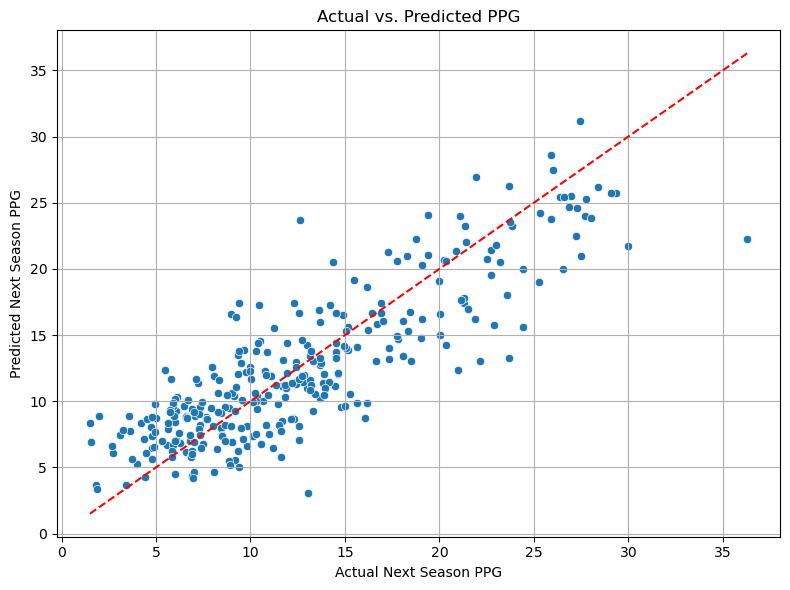

In [6]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  
plt.xlabel("Actual Next Season PPG")
plt.ylabel("Predicted Next Season PPG")
plt.title("Actual vs. Predicted PPG")
plt.grid(True)
plt.tight_layout()
plt.show()

**Description**

Linear Regression is a regression model. This means that it's used to predict a continuous numerical value, a player's predicted points per game (PPG) for the next season. The goal of this model is to find the linear relationship between the  current stats  and  (Next_PTS_per_game). The linear regression draws a straight line through the data in a way that best fits all the points. The model looks at patterns in the data and tries to draw a straight line that best fits the relationship between the players' current stats and their future performance. It learns how each stat affects the final prediction. Once it is trained, it can use new player stats to guess what their points per game might be.

**R2**

In [7]:
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

R² Score: 0.7337


**Cross Val Scores**

In [8]:
cv_scores = cross_val_score(estimator=model, X=X, y=y)

print("Cross-validation scores:", cv_scores)

Cross-validation scores: [0.7633345  0.56767395 0.78552075 0.68879372 0.67830869]


**Decision Tree**

Accuracy: 0.6045016077170418


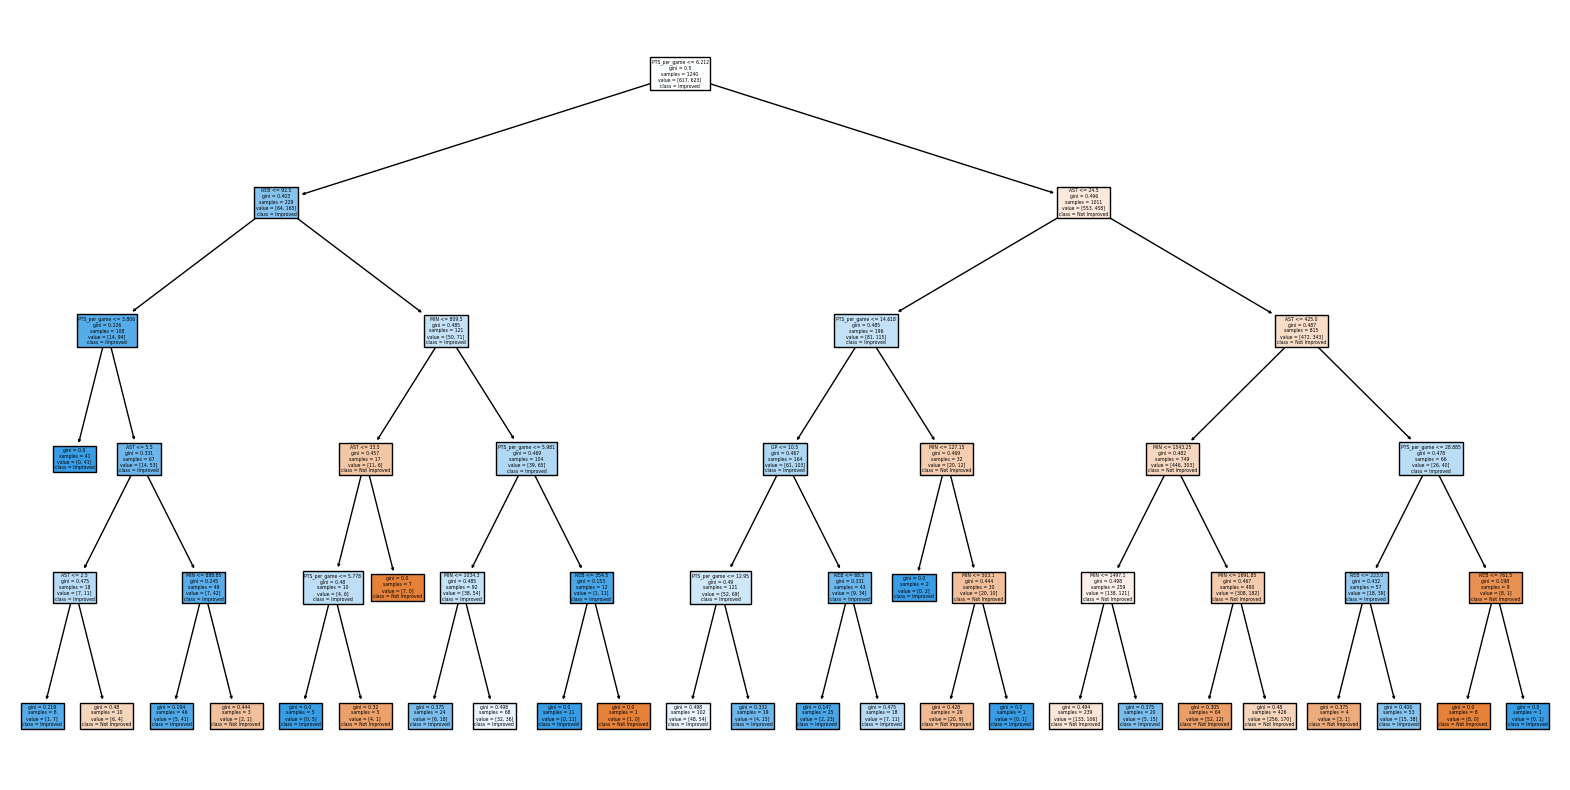

In [9]:
filtered_stats["Improved"] = (
    filtered_stats["Next_PTS_per_game"] > filtered_stats["PTS_per_game"]
).astype(int)


features = ["PTS_per_game", "AST", "REB", "GP", "MIN"]
filtered_stats = filtered_stats.dropna(subset=features)

X = filtered_stats[features]
y = filtered_stats["Improved"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))


plt.figure(figsize=(20,10))
plot_tree(model, feature_names=features, class_names=["Not Improved", "Improved"], filled=True)
plt.show()


**Description**

This is a classification model, which means it helps decide between different groups. Here, it tells us if a player is likely to improve or not improve their points per game next season. Decision trees are best at answering clear yes or no questions. The model works like a series of questions. It looks at a player's stats such as how many points, assists, or minutes they had. Furthermore, it asks simple yes/no questions to make a decision. In the end, it gives a prediction: improved or not. You can even see the steps it takes by looking at the tree diagram.

**Cross Val score**

In [10]:

clf = DecisionTreeClassifier(max_leaf_nodes = 5)
clf.fit(X, y)
cv_scores = cross_val_score(clf,X, y).mean()
print("Cross-validation scores:", cv_scores)

Cross-validation scores: 0.5931708329011512


**R2 Score**

In [11]:
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

R² Score: -0.5820099255583129


**Hyperparameter Tuning**

Best Hyperparameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}
Accuracy: 0.5819935691318328


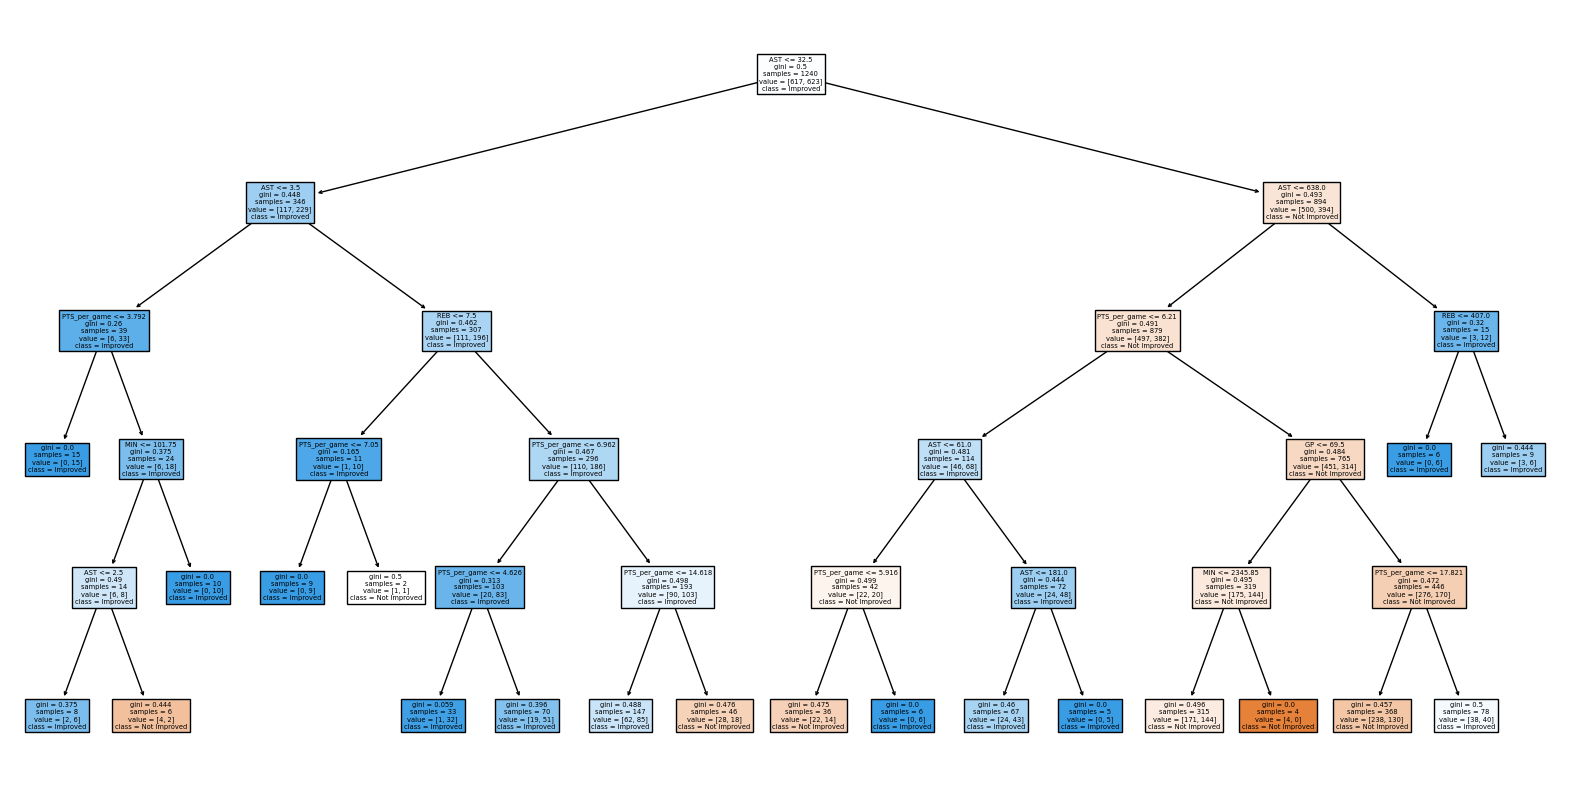

In [12]:
param_grid = {
    'max_depth': [3, 5, 10, None],  
    'min_samples_split': [2, 5, 10],  
    'max_features': [None, 'sqrt', 'log2'],  
    'min_samples_leaf': [1, 2, 4], 
}


tree_model = DecisionTreeClassifier(random_state=42)


grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='accuracy')


grid_search.fit(X_train, y_train)


print("Best Hyperparameters:", grid_search.best_params_)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))


plt.figure(figsize=(20,10))
plot_tree(best_model, feature_names=features, class_names=["Not Improved", "Improved"], filled=True)
plt.show()

**Summary and Findings**

The linear regression attempted to predict which players will improve the next season. The model is basic but does not do well on its own. The data needed to perform the best would be way more intensive and include things like injury history and whether or not the players will be on the same team. This is apparent in the r2 score. It shows that there are way more factors that has not been unpacked. The decision tree takes a players stats and predicts whether they will improve or not by using the process of elimination. Due to the accuracy score from the test data, the model was able to classify players majority of the time but not entirely due to the lack of other stats. With that being said, I can conclude that players with higher points per game are less likely to improve than a player who averaged lesser numbers. 